## Lab 3: final challenges

__Вам предлагается решить задачу классификации сигналов (вы уже встречались с ней во второй лабораторной работе) или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

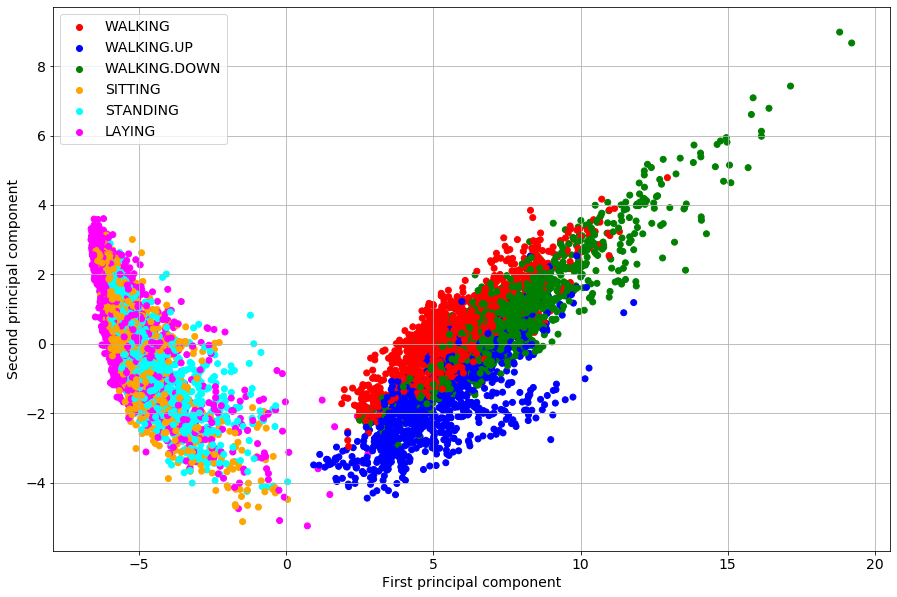

In [3]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [4]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [6]:
# Your experiments here


На кегле можно найти решение имеющее ~96% accuracy, но мы поставим перед собой задачу добится 92-93% и не будем использовать готовые фраемворки помимо pytorch, работать с которым мы уже умеем.

In [7]:
import numpy as np
import pandas as pd 
from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))

Using device: cpu


In [8]:
X_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
X_test = np.genfromtxt(os.path.join("UCI HAR Dataset", "test", "X_test.txt"))
# y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

In [9]:
#prepocessing

In [10]:
# le = LabelEncoder()

# X_train = train_data.iloc[:,0:(train_data.shape[1]-2)].values
# y_train = le.fit_transform(train_data.iloc[:,train_data.shape[1]-1].values)

# X_test = test_data.iloc[:,0:(test_data.shape[1]-2)].values
# y_test = le.transform(test_data.iloc[:,test_data.shape[1]-1].values)

In [11]:
## pca

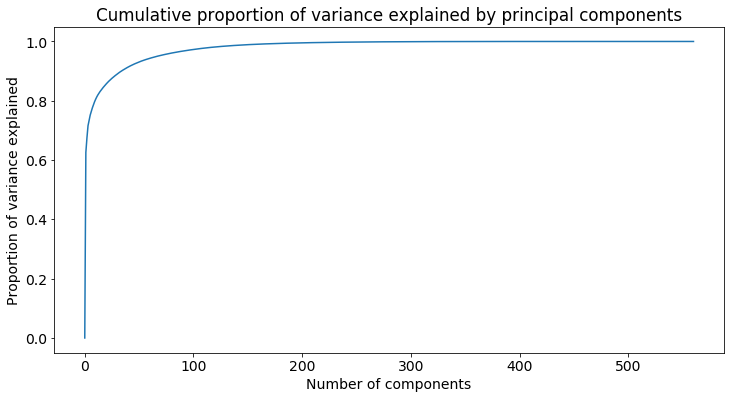

In [12]:
pca = PCA(n_components=X_train.shape[1])

pca.fit(X_train)
cumulative_variance = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(X_train.shape[1])]

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(cumulative_variance)
ax.set_title('Cumulative proportion of variance explained by principal components')
ax.set_xlabel('Number of components')
ax.set_ylabel('Proportion of variance explained')

plt.show()

In [13]:
# TSNE

In [14]:
tsne = TSNE()
y_train_ = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

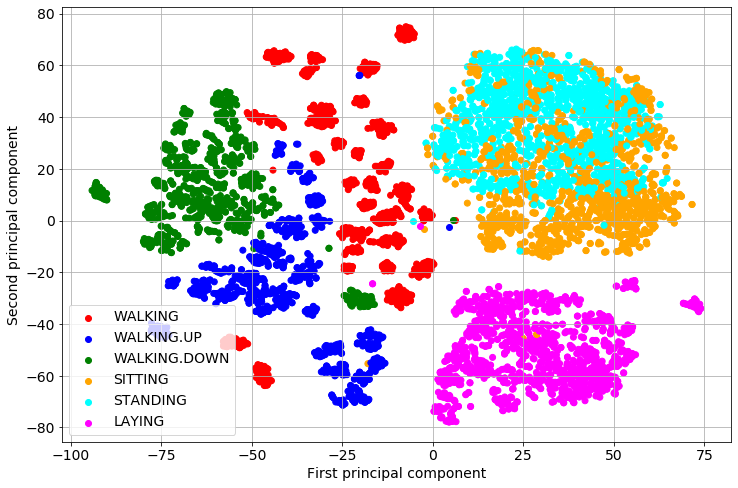

In [15]:
legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train_]

X_tsne = tsne.fit_transform(X_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train_)))])




plt.figure(figsize=(12,8))
pylab.scatter(X_tsne[:, 0], X_tsne[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

In [16]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_tets = le.fit_transform(y_test)

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# neural nnetwork 

In [17]:
NUM_CLASESS = 6 # количество классов 
FEATURES_NUM = X_train.shape[1] # количество признаков

class QuickModel(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        
        self.layer_sizes = layer_sizes
        
        structure = []
        for i in range(len(layer_sizes)):
            if i == len(layer_sizes) - 2:
                structure.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
                break
            else:
                structure.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
                structure.append(nn.ReLU())
                structure.append(nn.BatchNorm1d(layer_sizes[i+1]))
                structure.append(nn.Dropout(0.5))
                
        self.layers = nn.ModuleList(structure)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
def generateRandomArchitecture(num_layers=None, max_layers=10):
#     if num_layers is None:
#         if max_layers <= 3:
#             max_layers = 4
#         num_layers = np.random.randint(low=3, high=max_layers)

    layer_sizes = []
    
    for i in range(num_layers):
        if i == 0:
            layer_sizes.append(561)
        elif i == num_layers - 1:
            layer_sizes.append(NUM_CLASESS)
        else:
            layer_max = min(int(layer_sizes[-1] * 1.5), 2000)
            layer_min = int(layer_sizes[-1] / 3)
            
#             if layer_min < 6:
#                 layer_size = 6
#             else:
#                 layer_size = np.random.randint(low=layer_min, high=layer_max)
#             layer_sizes.append(layer_size)
    return layer_sizes, num_layers

In [18]:
nets = []

nets.append(QuickModel([561, 250, 6]).double())
nets.append(QuickModel([561, 124, 32, 16, 6]).double())
nets.append(QuickModel([561, 256, 256, 124, 64, 32, 16, 6]).double())
nets.append(QuickModel(generateRandomArchitecture(num_layers=12)[0]).double())
nets.append(QuickModel(generateRandomArchitecture(num_layers=15)[0]).double())
nets.append(QuickModel(generateRandomArchitecture(num_layers=20)[0]).double())

n_nets = len(nets)
nets_details = [(len(net.layer_sizes), net.layer_sizes) for net in nets]

for ii, net in enumerate(nets_details):
    print("Net {}: {} layers - {}".format(ii+1, net[0], net[1]))

Net 1: 3 layers - [561, 250, 6]
Net 2: 5 layers - [561, 124, 32, 16, 6]
Net 3: 8 layers - [561, 256, 256, 124, 64, 32, 16, 6]
Net 4: 2 layers - [561, 6]
Net 5: 2 layers - [561, 6]
Net 6: 2 layers - [561, 6]


In [20]:
for net in nets:
    net.to(device)

criterion = nn.CrossEntropyLoss()
# optimizers = [optim.SGD(net.parameters(), lr=0.003, momentum=0.9) for net in nets]
optimizers = [torch.optim.Adam(net.parameters()) for net in nets]

epochs = 800
# epochs = 500

train_losses = [[] for net in nets]
test_losses = [[] for net in nets]
test_accuracies = [[] for net in nets]
ensemble_accuracies, ensemble_aucs = [], []

best = [{} for net in nets]

for e in tqdm(range(epochs)):
    for net in nets:
        net.train()
    
    for ii, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        for optimizer in optimizers:
            optimizer.zero_grad()

        logits = [net(inputs).float() for net in nets]
        
        losses = []
        for logit in logits:
            losses.append(criterion(logit, labels))
        
        for loss in losses:
            loss.backward()
        
        for optimizer in optimizers:
            optimizer.step()
        
        for i in range(n_nets):
            train_losses[i].append(losses[i].item() / inputs.shape[0])
    
    test_loss = [0 for net in nets]
    accuracy = [0 for net in nets]
    
    for net in nets:
        net.eval()    
    for ii, (inputs, labels) in enumerate(test_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.no_grad():
            logits = [net(inputs) for net in nets]
            losses = [criterion(logit, torch.max(labels, 1)[1]) for logit in logits]
            
            for i in range(n_nets):
                test_loss[i] += losses[i].item() / inputs.shape[0]
            
            preds = [logit.argmax(dim=1) for logit in logits]
            for i in range(n_nets):
                correct = (preds[i] == labels).type(torch.FloatTensor)
                accuracy[i] += torch.mean(correct).item()

    for i in range(n_nets):
        if e == 0:
            best[i]['epoch'] = e
            best[i]['state_dict'] = nets[i].state_dict()
            best[i]['accuracy'] = accuracy[i] / len(test_dataloader)
        elif accuracy[i] / len(test_dataloader) > max(test_accuracies[i]):
            best[i]['epoch'] = e
            best[i]['state_dict'] = nets[i].state_dict()
            best[i]['accuracy'] = accuracy[i] / len(test_dataloader)
        
        test_losses[i].append(test_loss[i] / len(test_dataloader))
        test_accuracies[i].append(accuracy[i] / len(test_dataloader))

In [21]:
train_losses_averaged = [[] for net in nets]
interval = 250
for n in range(len(train_losses)):
    for i in range(0,len(train_losses[n]),interval):
        try:
            train_losses_averaged[n].append(np.mean(train_losses[n][i:i+interval]))
        except IndexError:
            train_losses_averaged[n].append(np.mean(train_losses[n][i:]))

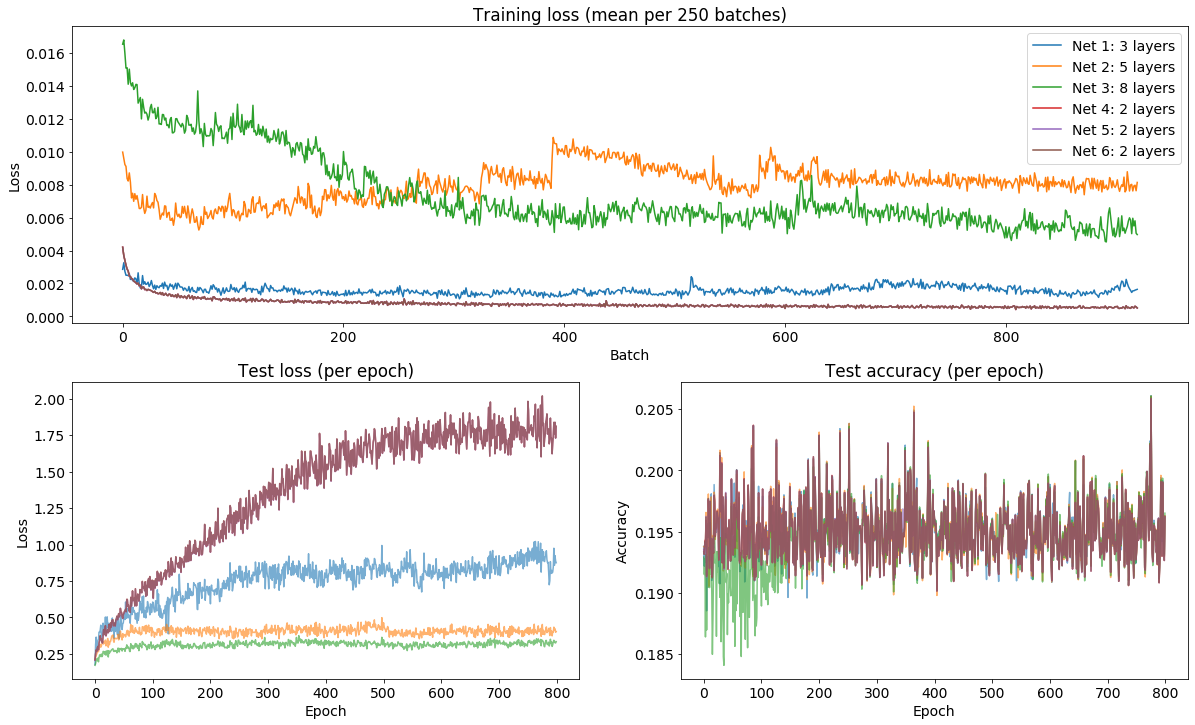

In [22]:
fig = plt.figure(figsize=(20,12))
gs = GridSpec(2, 2, figure=fig)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])

for i in range(n_nets):
    ax1.plot(train_losses_averaged[i], 
             label="Net {}: {} layers".format(i+1, nets_details[i][0]))
    ax2.plot(test_losses[i], alpha=0.6)
    ax3.plot(test_accuracies[i], alpha=0.6)

ax1.set_title('Training loss (mean per 250 batches)')
ax1.set_xlabel('Batch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')

ax2.set_title('Test loss (per epoch)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

ax3.set_title('Test accuracy (per epoch)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')

plt.show()

In [23]:
for i in range(n_nets):
    print("Net {}: {} layers, maximum test accuracy of {:.4f}".format(
        i+1, nets_details[i][0], best[i]['accuracy']))

Net 1: 3 layers, maximum test accuracy of 0.2061
Net 2: 5 layers, maximum test accuracy of 0.2061
Net 3: 8 layers, maximum test accuracy of 0.2061
Net 4: 2 layers, maximum test accuracy of 0.2059
Net 5: 2 layers, maximum test accuracy of 0.2059
Net 6: 2 layers, maximum test accuracy of 0.2059


In [24]:
for i in range(n_nets):
    nets[i].load_state_dict(best[i]['state_dict'])